# Class 8 - Parallelism in Julia

Today we'll talk a bit about Julia's built-in tecniques for taking advantage of parallelism, as well as Julia's MPI interface and the new parallel linear algebra package that wraps Elemental.

## Example: Monte Carlo Simulations

One of the many ways that computers have aided science is through simulation.  Sometimes you may not have a closed-form way to access a quantity of interest, and can obtain a good guess through running many simulations with parameters drawn from a distribution, and looking at the average behavior of your model.  This class of methods is known as [Monte Carlo methods](https://en.wikipedia.org/wiki/Monte_Carlo_method).  

One of the benefits of Monte Carlo methods is that they are often trivially parallelizable, since you can run independent experiments on separate processes, and then aggregate the results in a single round of communication at the end.

One of the great uses of Monte Carlo methods is [integration](https://en.wikipedia.org/wiki/Monte_Carlo_integration), which becomes increasingly attractive over high-dimensional domains.  The cannonical example is estimating $\pi$ by integrating a circle on a square domian.

The area of a circle with unit radius is $\pi r^2 = \pi$.
The area of a square on $[-1, 1]^2$ is 4.  If we place the unit circle in this square, the ratio of their areas is $\pi/4$.  The idea is that we sample uniformly on this square, and then see what portion of the points lie in the circle.  We know that this ratio should be approximately $\pi/4$, so re multiply the ratio by 4 to obtain our approximation of $\pi$.

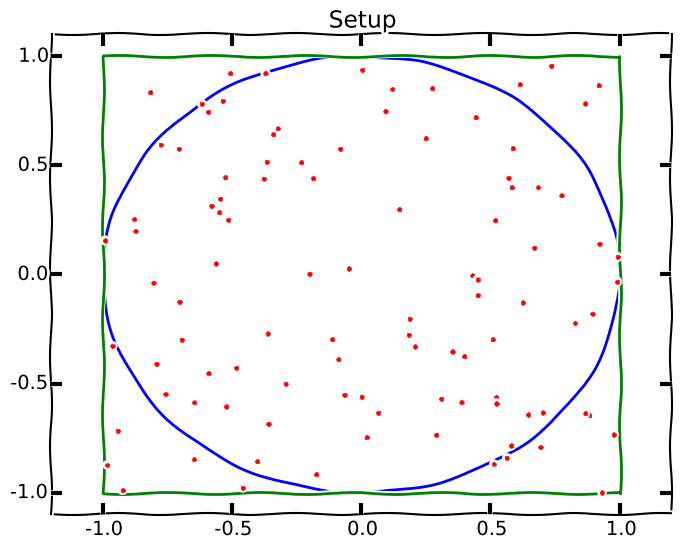

In [37]:
using PyPlot
θ = linspace(0,2π,1000)
circ_xs = cos(θ)
circ_ys = sin(θ)

sq_xs = [ 1, 1,-1,-1, 1]
sq_ys = [-1, 1, 1,-1,-1]

r_xs = rand(100) * 2 - 1
r_ys = rand(100) * 2 - 1

xkcd()
plot(circ_xs,circ_ys, "b-", sq_xs, sq_ys, "g-", r_xs, r_ys, "r.")
axis([-1.2, 1.2, -1.1, 1.1])
title("Setup")
show()
;

In [38]:
function π_monte_carlo(n_samples::Int64)
    n_circle = 0
    for i=1:n_samples
        x = rand() * 2 - 1
        y = rand() * 2 - 1
        r2 = x^2 + y^2
        if r2 <= 1
            n_circle += 1
        end
    end
    return (n_circle / n_samples) * 4
end

@time π_monte_carlo(10000000)

3.141706

0.172692 seconds (5.33 k allocations: 241.165 KB)


In [39]:
errors = Array(Float64,0)
n_pts = 2.^(6:30) # up to 1 billion
for n_samples in n_pts
    tic()
    push!(errors, π_monte_carlo(n_samples) - π)
    toc()
end
;

elapsed time: 1.445e-5 seconds
elapsed time: 1.2386e-5 seconds
elapsed time: 1.0318e-5 seconds
elapsed time: 1.7453e-5 seconds
elapsed time: 2.9412e-5 seconds
elapsed time: 5.8128e-5 seconds
elapsed time: 0.000111369 seconds
elapsed time: 0.00021956 seconds
elapsed time: 0.000500538 seconds
elapsed time: 0.000891582 seconds
elapsed time: 0.001736655 seconds
elapsed time: 0.003496376 seconds
elapsed time: 0.006705242 seconds
elapsed time: 0.01288149 seconds
elapsed time: 0.023848558 seconds
elapsed time: 0.041081412 seconds
elapsed time: 0.056141354 seconds
elapsed time: 0.103085496 seconds
elapsed time: 0.198871499 seconds
elapsed time: 0.405497228 seconds
elapsed time: 0.80541385 seconds
elapsed time: 1.659828427 seconds
elapsed time: 3.324850145 seconds
elapsed time: 6.38693403 seconds
elapsed time: 12.865587625 seconds


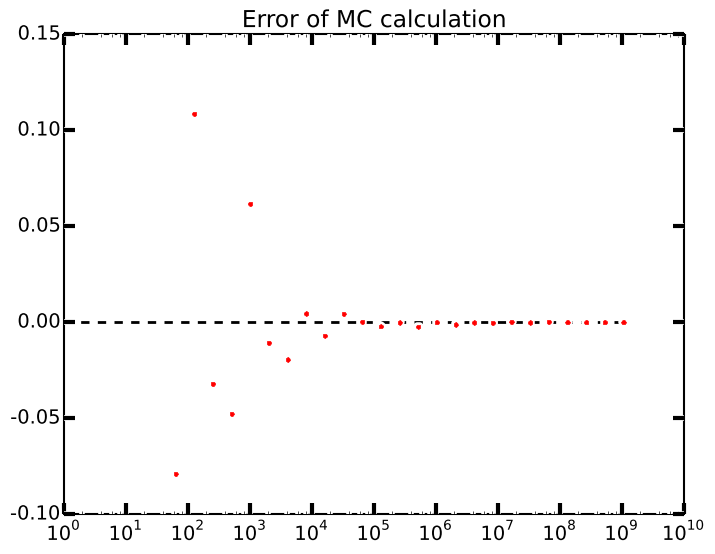

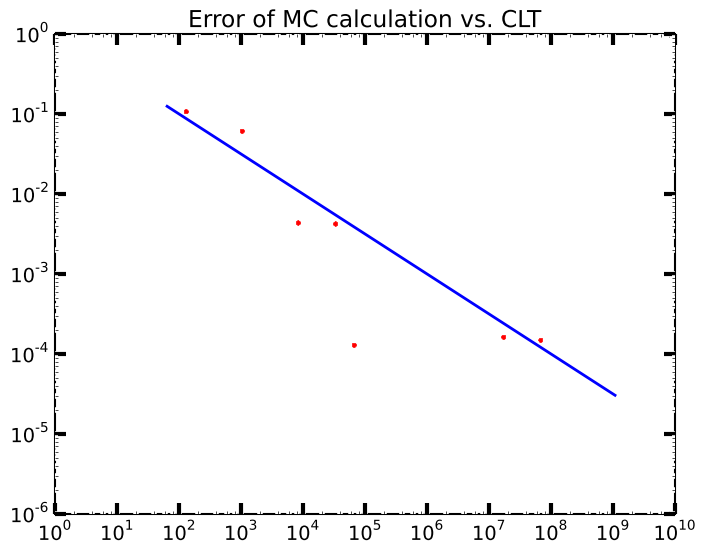

In [40]:
using PyPlot
xkcd(false)
show()
zx = [1, maximum(n_pts)]
zy = [0, 0]
semilogx(zx, zy ,"k--", n_pts, errors, ".r" )
title("Error of MC calculation")
show()

exp_acc = 1./ √(n_pts)

loglog(n_pts, exp_acc, abs(errors'), ".r")
title("Error of MC calculation vs. CLT")
show()
;

It takes us ~15 sec. to estimate $\pi$ on a billion points. However, this used only one core on the machine.  What if we want to use more?  

## Using more than one process

If you're starting up Julia in a terminal, you can use
```
julia -n 4
```
To indicate that 4 processes are available.  If you're using a IJulia notebook, you can add processes with `addprocs()`:

In [ ]:
@show nprocs()
addprocs(3)
@show nprocs()

(my machine has 4 cores).  Now, Julia will know that it can use up to 4 separate processes, but when you're writing code, you you need to explicitly use them.

In [ ]:
m = @spawn randn(2,2)

In [ ]:
fetch(m)

You need to make sure that all processes have access to functions that you define.  In order to define a function on all processes use the `@everywhere` macro

In [ ]:
function sum_test(a, b)
    a + b
end

In [ ]:
m = @spawn sum_test(1,2)

In [ ]:
fetch(m)

In [ ]:
@everywhere function sum_test(a, b)
    a + b
end

In [ ]:
m = @spawn sum_test(1,2)
fetch(m)

If you're loading modules, `using` will load them on all processes, but `include()` will not.

In [ ]:
using Distributions
d = @spawn Exponential()

In [ ]:
d2 = fetch(d)
rand(d2)

You can control which process is used with `@spawnat`

In [ ]:
p = @spawnat 2 1+1

In [ ]:
fetch(p)

If you want a result immediately, you can use `remotecall_fetch()`.  The first argument is the process, the second is a function, and following arguments will be passed to the function.

In [ ]:
remotecall_fetch(2, +, 1, 1)
#remotecall_fetch(2, 1+1)

The spawn/fetch commands are great for spinning off function evaluations.  If you want something that looks like a parallel for-loop, you can use the `@parallel` macro.  Note that this example does something like a MPI gather. (example from http://docs.julialang.org/en/release-0.4/manual/parallel-computing/)

In [ ]:
nheads = @parallel (+) for i=1:200000000
  Int(rand(Bool))
end

When you use a parallel for-loop, you should make sure that the inner contents of the loop are independent of each other, since you aren't controlling evaluation order, or which process is doing what.  Note that every process also uses its own copy of data, so something like the following will not work like you might wish it to.

In [ ]:
a = rand(100)
@parallel for i = 1:100
    a[i] = 1
end
@show a
;

If you want a distributed array, you can use the [DistributedArrays](https://github.com/JuliaParallel/DistributedArrays.jl) package.

## Exercise 1

* Modify the Monte Carlo calculation of $\pi$ above to use more than one process. (There's more than one way to do this!)
* How fast is your modified version compared to the single process version?
* Can you add the `@simd` macro to the for-loop?  How does this compare with parallelization?  What happens when you mix parallelization and `@simd`?

If you're stuck, there's a nice guide on doing this in Julia [here](http://mathemathinking.com/uncategorized/parallel-monte-carlo-in-julia/)

In [ ]:
function π_monte_carlo(n_samples::Int64)
    n_circle = 0
    for i=1:n_samples
        x = rand() * 2 - 1
        y = rand() * 2 - 1
        r2 = x^2 + y^2
        if r2 <= 1
            n_circle += 1
        end
    end
    return (n_circle / n_samples) * 4
end

@everywhere function π_monte_carlo_simd(n_samples::Int64)
    n_circle = 0
    @simd for i=1:n_samples
        x = rand() * 2 - 1
        y = rand() * 2 - 1
        r2 = x^2 + y^2
        if r2 <= 1
            n_circle += 1
        end
    end
    return (n_circle / n_samples) * 4
end



function π_monte_carlo_parallel(n_samples::Int64)
    n_circle = @parallel (+) for i=1:n_samples
        x = rand() * 2 - 1
        y = rand() * 2 - 1
        r2 = x^2 + y^2
        Int64(r2 <= 1)
    end
    return (n_circle / n_samples) * 4
end

function π_monte_carlo_parallel_simd(n_samples::Int64)
    num_proc = nprocs()
    n_per_proc = div(n_samples, num_proc)
    jobs = []
    for proc = num_proc:-1:2
        push!(jobs, @spawnat proc π_monte_carlo_simd(n_per_proc) )
    end
    n_circle = remotecall_fetch(1, π_monte_carlo_simd, n_per_proc + mod(n_samples, num_proc))
    for proc = num_proc:-1:2
        n_circle += fetch(pop!(jobs))
    end
    return n_circle
end
;

In [ ]:
@show n = 100000000
@time π_monte_carlo(n)
@time π_monte_carlo_simd(n)
@time π_monte_carlo_parallel(n)
@time π_monte_carlo_parallel_simd(n)

# Arrays

As mentioned above, if you wish to have multiple processes work on a single array you need to go above an beyond the limitiations of a standard array.  There are two types of arrays you may wish to use for parallel/distributed computations:

* [Shared Arrays](http://docs.julialang.org/en/release-0.4/manual/parallel-computing/#shared-arrays) - built into Julia - all processes can access any element of the array
* [Distributed Arrays](https://github.com/JuliaParallel/DistributedArrays.jl) - package through JuliaParallel - array elements are distributed over processes.

### Shared Arrays

[Shared Arrays](http://docs.julialang.org/en/release-0.4/manual/parallel-computing/#shared-arrays) are accessible from all processes and maintain the same data.

In [ ]:
addprocs(3)

In [ ]:
S = SharedArray(Int, (3,4), init = S -> S[Base.localindexes(S)] = myid())

The first argument is the type of the array elements, the second argument is a tuple of dimensions, the (optional) third argument is an initialization function, and the (optional) fourth argument denotes what processes the Shared Array should be shared on.

In [ ]:
S = SharedArray(Int, (3,4), init = S -> S[indexpids(S):length(procs(S)):length(S)] = myid())

In [ ]:
p = @spawnat 2 S[1] = 7
fetch(p)
S # displayed by process 1

### Distributed Arrays

[Distributed Arrays](https://github.com/JuliaParallel/DistributedArrays.jl) are offered from [Julia Parallel](https://github.com/JuliaParallel) to distribute an array over several processes.  If you've done distributed linear algebra before, this is probably more familiar than the SharedArray.

In [ ]:
using DistributedArrays

In [ ]:
B = drandn(5, 5)
println(B)
A = @DArray [i+j for i = 1:5, j = 1:5]
println(A)

Distributed arrays will change the order of operations, so you should expect to see differences due to floating point errors when you perform operations with DArrays.

In [ ]:
A = randn(100,100)
@show s1 = sum(A)
D = distribute(A)
@show s2 = sum(D)
@show s1 - s2
;

## Exercise 2

* Can you use linear algebra routines (such as SVD) on SharedArrays?  What about DArrays?  What is the type of the output?

# Using Julia with MPI

Most of what we've considered above is useful for using multiple cores on a single machine.  What if you want to run Julia on a cluster?  Julia provides a [MPI package](https://github.com/JuliaParallel/MPI.jl) that allows you to run Julia scripts with `mpirun` just as you would with C/Fortran binaries.

If you haven't used it before, [MPI](https://computing.llnl.gov/tutorials/mpi/) is the Message Passing Interface Standard.  The standard has several implementations - the most popular are [MPICH](https://www.mpich.org/) and [OpenMPI](http://www.open-mpi.org/) (both are open source), which you can get for your system using almost any repository manager.  Corn.stanford has OpenMPI, I have MPICH. In practice, the two are mostly interchangable, although they use slightly different syntax if you use a [hostfile](https://www.open-mpi.org/faq/?category=running).

If you haven't used MPI before, it is worth looking at it a bit if you are interested in scientific computing.  The appeal in Julia is that it allows you finer control when writing algorithms that may use several cores or machines.

### Example
See the script [here](mpi_test.jl)
```bash
mpirun -np 4 julia mpi_test.jl
```
(note that if julia is an alias, then mpirun will throw an error).

You can also use Julia's MPI interface to simply initialize MPI, and then call C/Fortran libraries that use it more extensively.  This is what we see with the Elemental package.

# Distributed Linear Algebra with Elemental

[Elemental](https://github.com/elemental/Elemental) is a library for distributed linear algebra primarily written and maintained by [Jack Poulson](http://web.stanford.edu/~poulson/).  It was recently wrapped by Julia Parallel so you can now do your HPC linear algebra from Julia.  Right now you'll need to clone [Elemental.jl](https://github.com/JuliaParallel/Elemental.jl) using `Pkg.clone()` to use it.

In [ ]:
using Elemental
const El = Elemental

In [ ]:
# example from Elemental.jl's tests
using Base.Test
using Elemental
using DistributedArrays

A = drandn(50,50)
Al = convert(Array, A)
B = drandn(50,10)
Bl = convert(Array, B)

@test Al\Bl ≈ A\B
@test svdvals(Al) ≈ Elemental.svdvals(A)

Elemental provides a DistMatrix type, which will have entries distributed over processes similar to a Julia DArray.

In [ ]:
M = El.DistMatrix(Float64)
El.gaussian!(M, 100, 100)

In [ ]:
b = El.DistMatrix(Float64)
El.ones!(b, 100, 1)
x = El.lav(M,b) # Mx = b

Elemental.jl is still being developed, and a lot of the library's C++ functionality is still not available through the Julia interface.

## Exercise 3

* try running one of the [examples](https://github.com/JuliaParallel/MPI.jl/tree/master/examples) in MPI.jl on corn.stanford.
* (if you have time) try compiling Elemental.jl on your system (or corn), and see how fast you can do matrix-vector multiplication.